In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
from itertools import chain

import nltk
import numpy as np
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [3]:
def word2features(sent, acts, slots, i, for_acts = True, train = True):
    word = sent[i]
    postag = slots[i] if for_acts else acts[i]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word[:3]': word[:3],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        
    }
    if train:
        if postag!='O':
            features['postag[2:]'] = postag[2:]
        features['postag[0]'] = postag[0],
        features['postag'] = postag
        
    if i > 0:
        word1 = sent[i-1]
        postag1 = slots[i-1] if for_acts else acts[i-1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:word[-3:]': word1[-3:],
        })
        if train:
            if postag1!='O':
                features['-1:postag[2:]'] = postag1[2:]
            features['-1:postag[0]'] = postag1[0],
            features['-1:postag'] = postag1
    else:
        features['BOS'] = True # begin of sentence

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = slots[i+1] if for_acts else acts[i+1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:word[-3:]': word1[-3:],
        })
        if train:
            if postag1!='O':
                features['+1:postag[2:]'] = postag1[2:]
            features['+1:postag[0]'] = postag1[0],
            features['+1:postag'] = postag1
    else:
        features['EOS'] = True # end of sentence

    return features


def sent2features(sent, acts, slots, for_acts = True, train = True):
    """
    input looks like:
        sent = ['okay', 'and', 'can', 'i', 'get', 'their', 'phone']
        acts = ['O', 'O', 'O', 'O', 'O', 'O', 'B-request']
        slots = ['O', 'O', 'O', 'O', 'O', 'O', 'B-phone']
        
    here for_acts=True means that you would like to make features to predict acts;
    if you want predict slots you should pass for_acts=False;
    
    """
    return [word2features(sent, acts, slots, i, for_acts=for_acts, train = train) for i in range(len(sent))]

def batch2features(x_words, m_slots, m_acts, DataGen, for_acts = True, train = True):
    
    feats = []
    for x_, m1_, m2_ in zip(x_words, m_slots, m_acts):
        sent = DataGen.decode_sentence(x_)
        slots = DataGen.decode_slots(m1_)
        acts = DataGen.decode_acts(m2_)
        feats.append(sent2features(sent, acts, slots, for_acts = for_acts, train = train))
    return feats

In [4]:
from data_generator import NLUDataGenerator

batch_size = 3800
TimeMajor = False

DataGenDev = NLUDataGenerator('../data/dev/usr_df_final.csv',
                           '../data/ontology_dstc2.json',
                           '../data/slots', None,
                           batch_size = int(batch_size*0.6), time_major=TimeMajor)

DataGen = NLUDataGenerator('../data/train/usr_df_final.csv',
                           '../data/ontology_dstc2.json',
                           '../data/slots', DataGenDev.vocab,
                           batch_size = batch_size, time_major=TimeMajor)

len(diff):  175
tmp len:  175
before:  712
fin:  887


In [6]:
x, m1, m2, _lens = next(DataGen)
X_train_acts = batch2features(x, m1, m2, for_acts=True, DataGen=DataGen, train=False)
y_train_acts = [DataGen.decode_acts(m) for m in m2]

In [7]:
x, m1, m2, _lens = next(DataGenDev)
X_test_acts = batch2features(x, m1, m2, for_acts=True, DataGen=DataGenDev, train=False)
y_test_acts = [DataGenDev.decode_acts(m) for m in m2]

In [8]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train_acts, y_train_acts)

CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=0.1, c2=0.1,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

In [9]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B-bye',
 'B-inform',
 'B-request',
 'I-request',
 'B-reqalts',
 'B-affirm',
 'I-inform',
 'B-negate',
 'B-confirm',
 'I-confirm',
 'B-hello',
 'I-affirm',
 'I-negate']

In [25]:
y_pred = crf.predict(X_test_acts)
metrics.flat_f1_score(y_test_acts, y_pred,
                      average='weighted', labels=labels)

0.89983953377455739

In [26]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test_acts, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

   B-affirm      0.678     0.336     0.449       119
   I-affirm      0.000     0.000     0.000         0
      B-bye      0.939     0.963     0.951       240
  B-confirm      0.533     0.314     0.395        51
  I-confirm      1.000     1.000     1.000         1
    B-hello      1.000     0.200     0.333        30
   B-inform      0.932     0.978     0.955      1594
   I-inform      0.975     0.765     0.857        51
   B-negate      0.606     0.576     0.590       139
   I-negate      0.000     0.000     0.000         1
  B-reqalts      0.911     0.626     0.742       131
  B-request      0.971     0.954     0.963       808
  I-request      0.959     0.955     0.957       222

avg / total      0.916     0.897     0.900      3387



# Top transitions

In [27]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
B-bye  -> B-bye   6.370684
B-hello -> B-hello 5.778698
B-reqalts -> B-reqalts 5.693420
B-inform -> I-inform 5.488436
B-negate -> B-negate 5.408583
B-affirm -> B-affirm 4.950129
I-inform -> I-inform 4.605797
B-confirm -> I-confirm 4.057404
B-negate -> I-negate 3.886139
O      -> O       3.843271
B-request -> I-request 3.663187
I-request -> I-request 3.528743
O      -> B-inform 2.611999
B-confirm -> B-confirm 2.579517
O      -> B-request 2.226143
I-negate -> I-negate 1.615390
I-inform -> O       1.612933
B-affirm -> I-affirm 1.598496
B-inform -> O       1.553189
O      -> B-confirm 1.536611

Top unlikely transitions:
B-inform -> I-confirm -2.061808
B-request -> B-negate -2.215474
B-request -> B-affirm -2.286548
B-affirm -> B-bye   -2.430339
B-confirm -> B-inform -2.572549
O      -> B-hello -2.666213
B-affirm -> B-request -2.902916
O      -> I-inform -2.949876
B-request -> B-inform -3.238438
B-bye  -> O       -3.262927
B-negate -> B-request -3.302938
B-reqalts -> B

# State features

In [13]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
5.818701 B-request word[:3]:add
4.344209 B-confirm -1:word.lower():that
4.215527 B-negate -1:word.lower():no
4.215527 B-negate -1:word[-3:]:no
4.028601 B-confirm -1:word.lower():it
4.028601 B-confirm -1:word[-3:]:it
4.007151 O        word.lower():can
3.951948 O        word.lower():bristish
3.942710 B-request word[:3]:pri
3.585149 B-affirm word[:3]:yea
3.509908 O        word[:3]:sig
3.313742 B-inform word.lower():moderate
3.302882 O        word.lower():modereate
3.148048 B-request word.lower():number
3.148048 B-request word[:3]:num
3.108888 B-affirm -1:word.lower():yes
3.108888 B-affirm -1:word[-3:]:yes
3.070680 B-request word.lower():telephone
3.010560 B-reqalts word[:3]:els
3.006705 B-request word[:3]:pos
2.897651 B-request word.lower():area
2.897651 B-request word[-3:]:rea
2.864230 O        word.lower():portugese
2.812176 O        bias
2.802059 B-inform word[-3:]:que
2.722537 O        word[-3:]:ter
2.698428 O        word.lower():malyasian
2.692207 B-request word[-3:]:os

# Params search

In [14]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train_acts, y_train_acts)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside

/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside

/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside

/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside

/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside

/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside

/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside

/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside

/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside

CPU times: user 27.7 s, sys: 2.24 s, total: 30 s
Wall time: 6min 40s


In [15]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.003020247418494537, 'c2': 0.042603304765036605}
best CV score: 0.941982929801208
model size: 0.19M


In [16]:
crf = rs.best_estimator_

In [28]:
y_pred = crf.predict(X_test_acts)
metrics.flat_f1_score(y_test_acts, y_pred,
                      average='weighted', labels=labels)

0.89983953377455739

In [29]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test_acts, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

   B-affirm      0.678     0.336     0.449       119
   I-affirm      0.000     0.000     0.000         0
      B-bye      0.939     0.963     0.951       240
  B-confirm      0.533     0.314     0.395        51
  I-confirm      1.000     1.000     1.000         1
    B-hello      1.000     0.200     0.333        30
   B-inform      0.932     0.978     0.955      1594
   I-inform      0.975     0.765     0.857        51
   B-negate      0.606     0.576     0.590       139
   I-negate      0.000     0.000     0.000         1
  B-reqalts      0.911     0.626     0.742       131
  B-request      0.971     0.954     0.963       808
  I-request      0.959     0.955     0.957       222

avg / total      0.916     0.897     0.900      3387



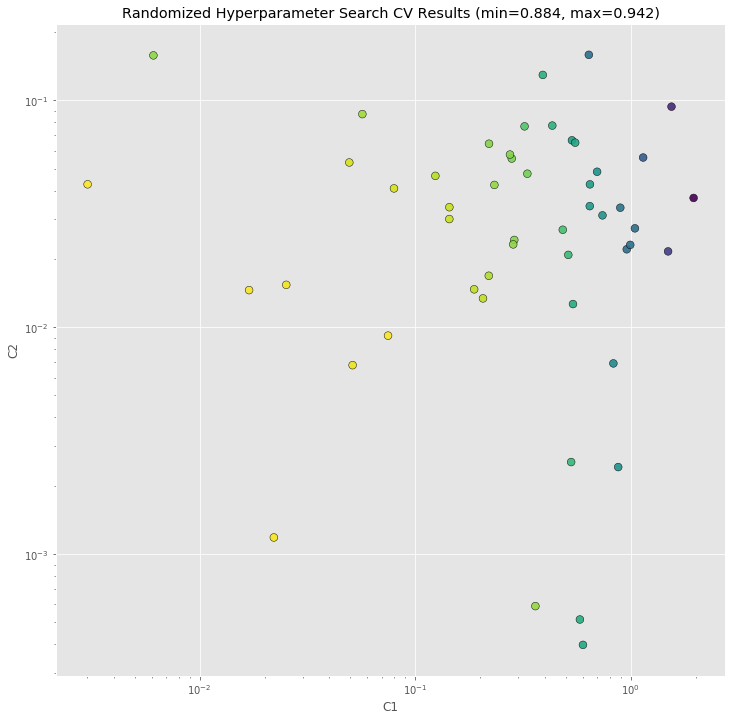

In [22]:
_x = [s.parameters['c1'] for s in rs.grid_scores_]
_y = [s.parameters['c2'] for s in rs.grid_scores_]
_c = [s.mean_validation_score for s in rs.grid_scores_]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])
